In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [76]:
df = pd.read_csv('AntibioticSales.csv')

# EDA

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    204 non-null    object 
 1   Time    204 non-null    int64  
 2   Month   204 non-null    int64  
 3   Year    204 non-null    int64  
 4   Sales   204 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 8.1+ KB


In [78]:
df.isnull().sum()

Date     0
Time     0
Month    0
Year     0
Sales    0
dtype: int64

In [79]:
df.describe()

,Time,Month,Year,Sales
count,204.000000,204.000000,204.000000,204.000000
mean,102.500000,6.500000,1999.500000,10.694430
std,59.033889,3.460545,4.936543,5.956998
min,1.000000,1.000000,1991.000000,2.814520
25%,51.750000,3.750000,1995.000000,5.844095
50%,102.500000,6.500000,1999.500000,9.319345
75%,153.250000,9.250000,2004.000000,14.289964
max,204.000000,12.000000,2008.000000,29.665356


In [80]:
df.head()

,Date,Time,Month,Year,Sales
0,07/1991,1,7,1991,3.526591
1,08/1991,2,8,1991,3.180891
2,09/1991,3,9,1991,3.252221
3,10/1991,4,10,1991,3.611003
4,11/1991,5,11,1991,3.565869


In [81]:
df.columns

Index(['Date', 'Time', 'Month', 'Year', 'Sales'], dtype='object')

In [82]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
df.set_index('Date', inplace=True)
ts = df['Sales']


In [83]:
sns.set(style="whitegrid")

In [84]:
print("Summary Statistics:\n", ts.describe())

Summary Statistics:
 count    204.000000
mean      10.694430
std        5.956998
min        2.814520
25%        5.844095
50%        9.319345
75%       14.289964
max       29.665356
Name: Sales, dtype: float64


Summary Statistics:
 count    204.000000
mean      10.694430
std        5.956998
min        2.814520
25%        5.844095
50%        9.319345
75%       14.289964
max       29.665356
Name: Sales, dtype: float64


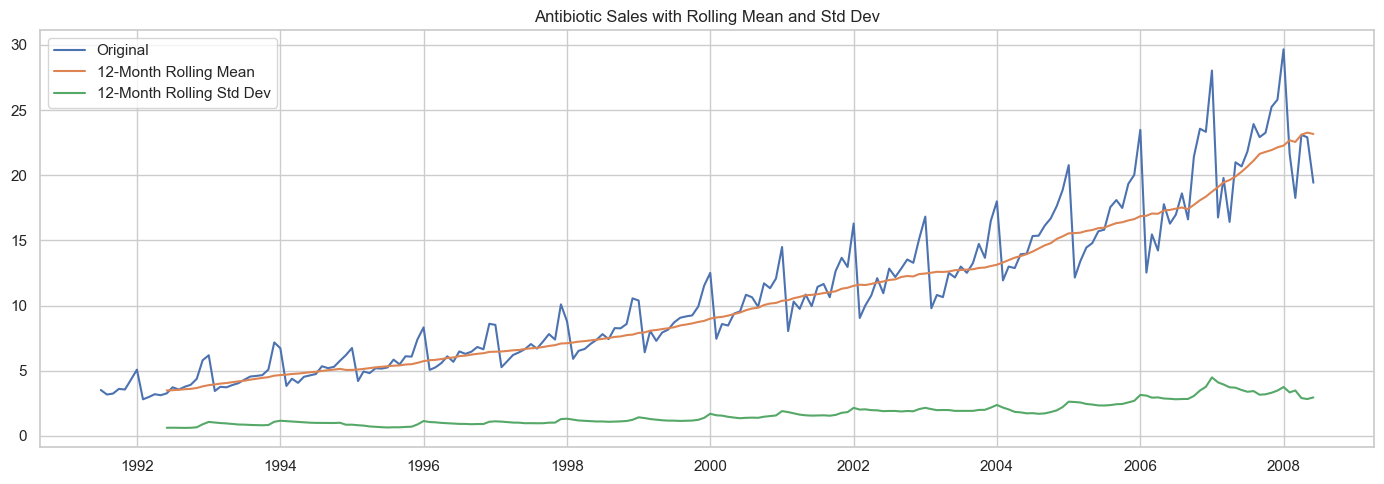

In [85]:

# Summary stats
print("Summary Statistics:\n", ts.describe())

# Rolling mean & std
ts_rolling_mean = ts.rolling(window=12).mean()
ts_rolling_std = ts.rolling(window=12).std()

plt.figure(figsize=(14, 5))
plt.plot(ts, label="Original")
plt.plot(ts_rolling_mean, label="12-Month Rolling Mean")
plt.plot(ts_rolling_std, label="12-Month Rolling Std Dev")
plt.title("Antibiotic Sales with Rolling Mean and Std Dev")
plt.legend()
plt.tight_layout()
plt.show()

In [86]:
from statsmodels.tsa.stattools import adfuller

In [87]:
def test_stationarity(ts):
    dftest= adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [88]:
print("Results of Dickey-Fuller Test:")
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   3.145186
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [89]:
#it is not stationary so 
ts_log = np.log(ts)
ts_log_diff = ts_log.diff().dropna()
ts_log_diff_seasonal = ts_log_diff.diff(12).dropna()



In [90]:
print("Results of Dickey-Fuller Test:")
test_stationarity(ts_log_diff_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                  -4.785546
p-value                          0.000058
#Lags Used                      13.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64


## arima building and modeling

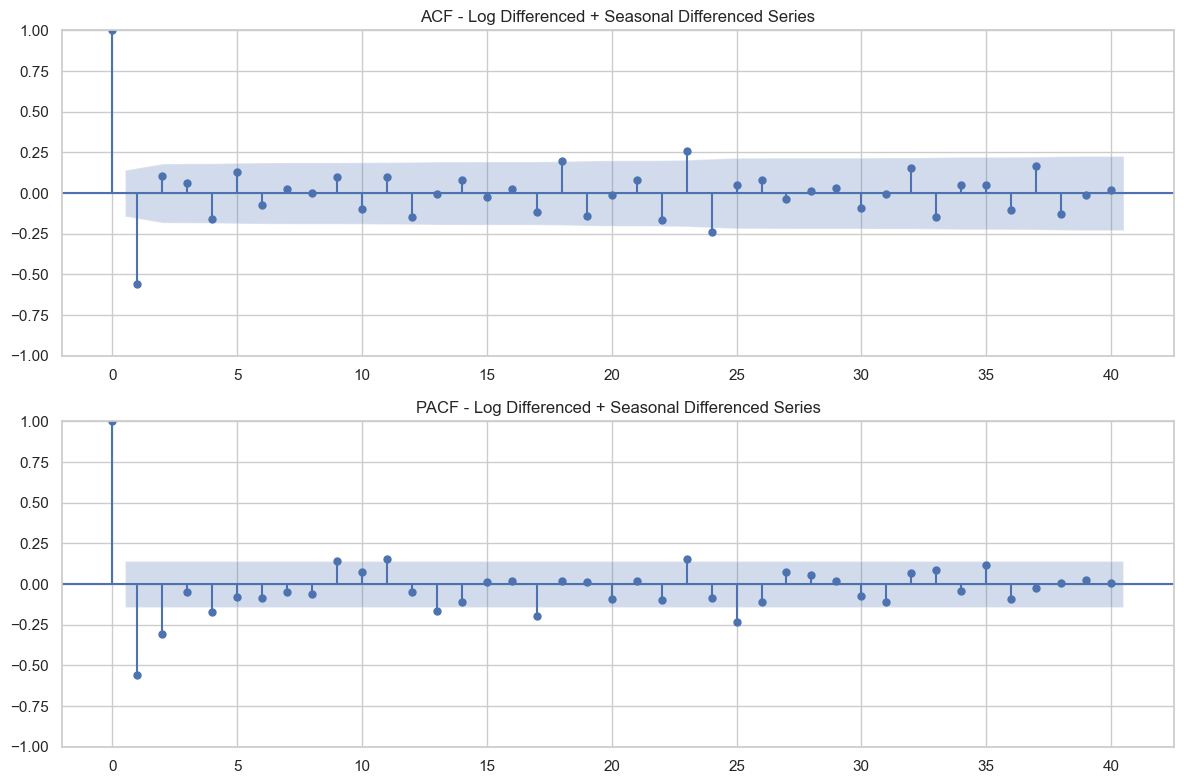

In [91]:



# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF: helps determine MA(q)
plot_acf(ts_log_diff_seasonal, lags=40, ax=axes[0])
axes[0].set_title("ACF - Log Differenced + Seasonal Differenced Series")

# PACF: helps determine AR(p)
plot_pacf(ts_log_diff_seasonal, lags=40, ax=axes[1])
axes[1].set_title("PACF - Log Differenced + Seasonal Differenced Series")

plt.tight_layout()
plt.show()


In [92]:
split_index = int(len(ts_log) * 0.8)  # 80% for training
# 20% for testing
ts_train = ts_log.iloc[:split_index]
ts_test = ts_log.iloc[split_index:]

In [97]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(ts_train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_prediction = arima_result.predict(steps=len(ts_test))


c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# SARIMA(1,1,1)(1,1,1)[12]
sarima_model = SARIMAX(ts_train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()
sarima_prediction = sarima_result.predict(start=len(ts_test))


c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ronjd\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [99]:
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
arima_rmse = np.sqrt(mean_squared_error(ts_test, arima_prediction))
sarima_rmse = np.sqrt(mean_squared_error(ts_test, sarima_prediction))
arima_mae = mean_absolute_error(ts_test, arima_prediction)
sarima_mae = mean_absolute_error(ts_test, sarima_prediction)

print("ARIMA RMSE:", arima_rmse, "| MAE:", arima_mae)
print("SARIMA RMSE:", sarima_rmse, "| MAE:", sarima_mae)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ts_test.index, ts_test, label="Actual Sales", color="black")
plt.plot(ts_test.index, arima_prediction, label="ARIMA Forecast", color="blue")
plt.plot(ts_test.index, sarima_prediction, label="SARIMA Forecast", color="green")
plt.title("ARIMA vs SARIMA Forecast on Test Set")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [41, 163]